Thanks to this article https://medium.com/analytics-vidhya/primer-on-gps-data-with-strava-and-python-cd7c6c1d715a and https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418/

Uses this library https://pypi.org/project/gpxpy/

In [1]:
import gpxpy

path = '../Strava/L_Etape_2023.gpx'

with open(path, 'r') as f:
   gpx = gpxpy.parse(f)

print('Tracks ',len(gpx.tracks))
print(gpx.tracks[0].name)
print('Segments ', len(gpx.tracks[0].segments))
print('Segment Points ', len(gpx.tracks[0].segments[0].points))

data = gpx.tracks[0].segments[0].points

track = gpx.tracks[0]
segment = track.segments[0]
random_point = segment.points[11144]
point = random_point
last_point = segment.points[11143]
random_point

Tracks  1
L’Etape 2023 Annemasse to Morzine
Segments  1
Segment Points  32724


GPXTrackPoint(46.300493, 6.507359, elevation=1053.4, time=datetime.datetime(2023, 7, 9, 9, 28, 32, tzinfo=SimpleTZ('Z')))

In [2]:
import mpu

power = None
hr = None
cadence = None
temp = None
# Safely access extensions
for ext in point.extensions:
    if ext.tag.endswith('power'):
        power = ext.text
    if ext is not None:
        for child in ext:
            if (child.tag.endswith('hr')):
                hr = child.text
            if (child.tag.endswith('cad')):
                cadence = child.text
            if (child.tag.endswith('atemp')):
                temp = child.text
duration = point.time - last_point.time
dist = mpu.haversine_distance((point.latitude, point.longitude), (last_point.latitude, last_point.longitude))
print(dist)  # gives 278.45817507541943.
print(duration)
print(point.latitude)
print(power)
print(cadence)
print(hr)

0.002780934451155232
0:00:01
46.300493
181
60
163


In [3]:
import pandas as pd

df = pd.DataFrame(columns=['lat', 'lon', 'ele','time','power', 'hr', 'cad','temperature'
# don't add empty columns                           ,'distance','alt_difference', 'duration'
                           ])
last_point = None
for point in data:
    power = None
    hr = None
    cadence = None
    temp = None
    # Safely access extensions
    for ext in point.extensions:
        if ext.tag.endswith('power'):
            power = int(ext.text)
        if ext is not None:
            for child in ext:
                if (child.tag.endswith('hr')):
                    hr = int(child.text)
                if (child.tag.endswith('cad')):
                    cadence = int(child.text)
                if (child.tag.endswith('atemp')):
                    temp = float(child.text)
    new_row = pd.DataFrame({'lat': [point.latitude],
                            'lon': [point.longitude],
                            'ele': [point.elevation],
                            'time': [point.time],
                            'power': [power]
                            ,'hr': [hr],
                            'cad': [cadence]
                            ,'temperature': [temp]
                            })
    df = pd.concat([df, new_row], ignore_index=True)



/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_99589/1551890944.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [4]:
df['hr'] = df['hr'].astype(int)
df['cad'] = df['cad'].astype(int)
df['power'] = df['power'].astype(float)
df['temperature'] = df['temperature'].astype(float)

Gradient will affect cadence, especially on long or steep climbs.

New riders will tend to not use gears to overcome gradient and tend to power through, and I know when I'm fatigued, I do this.

In [5]:
import numpy as np
import geopy.distance

df['distance'] = pd.Series(dtype='float')
df['alt_difference'] = pd.Series(dtype='float')
df['duration'] = pd.Series(dtype='float')
df['velocity'] = pd.Series(dtype='float')

for i in range(1, len(df)):
    coords_1 = (df.loc[i-1, 'lat'],df.loc[i-1, 'lon'])
    coords_2 = (df.loc[i, 'lat'],df.loc[i, 'lon'])
    distance = geopy.distance.geodesic(coords_1, coords_2).m
    elevation =  df.loc[i, 'ele'] - df.loc[i-1, 'ele']
    duration = (df.loc[i, 'time'] - df.loc[i-1, 'time']).total_seconds()
    # filter out odd gps coords
    if distance > 30 or distance == 0:
        distance = None
        elevation = None
        duration = None
    if distance is not None and elevation is not None:
        velocity = 3.6 * np.sqrt(distance**2 + elevation**2)
    else:
        velocity = None
    df.loc[i, 'distance'] = distance
    df.loc[i, 'alt_difference'] = elevation
    df.loc[i, 'velocity'] = velocity
    df.loc[i, 'duration'] = duration

Probably need to add some labels here:

- Heart Rate Zone
- Power zone

Suspect the big label for me is gradient, and I'm probably not that well-rounded in my training.

In [6]:
df

,lat,lon,ele,time,power,hr,cad,temperature,distance,alt_difference,duration,velocity
0,46.180331,6.245169,441.2,2023-07-09 06:15:52+00:00,NaN,100,2,25.0,NaN,NaN,NaN,NaN
1,46.180315,6.245162,441.2,2023-07-09 06:15:53+00:00,NaN,100,2,25.0,1.858790,0.0,1.0,6.691643
2,46.180299,6.245154,441.2,2023-07-09 06:15:54+00:00,NaN,100,2,25.0,1.882690,0.0,1.0,6.777686
3,46.180282,6.245146,441.2,2023-07-09 06:15:55+00:00,NaN,100,2,25.0,1.988027,0.0,1.0,7.156898
4,46.180261,6.245137,441.0,2023-07-09 06:15:56+00:00,NaN,100,2,25.0,2.435492,-0.2,1.0,8.797283
...,...,...,...,...,...,...,...,...,...,...,...,...
32719,46.182777,6.705971,972.8,2023-07-09 17:02:24+00:00,0.0,106,0,26.0,0.501334,0.0,1.0,1.804803
32720,46.182779,6.705970,972.8,2023-07-09 17:02:25+00:00,0.0,105,0,26.0,0.235335,0.0,1.0,0.847207
32721,46.182781,6.705970,972.8,2023-07-09 17:02:26+00:00,0.0,105,0,26.0,0.222310,0.0,1.0,0.800315
32722,46.182781,6.705970,972.8,2023-07-09 17:02:27+00:00,0.0,106,0,26.0,NaN,NaN,NaN,NaN


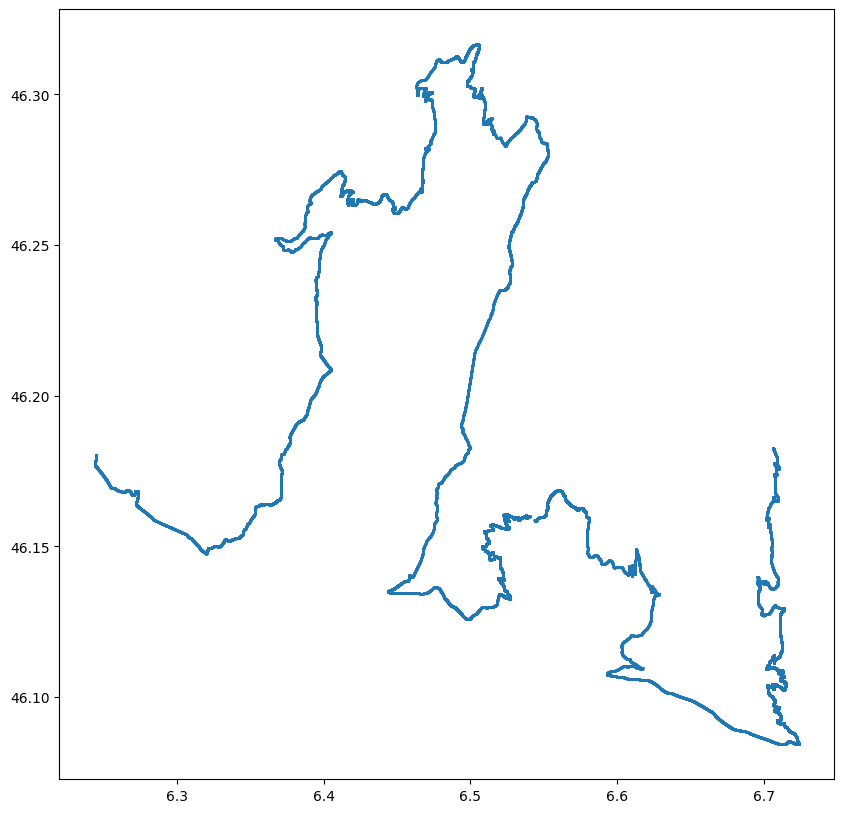

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(df.lon, df.lat, 'o', markersize=1)

time column with time zone causes issues with plotting functions.
Turn the time column into an index

In [8]:
df['time'] = df['time'].dt.tz_localize(None)
df = df.set_index('time')
df.head()

,lat,lon,ele,power,hr,cad,temperature,distance,alt_difference,duration,velocity
time,,,,,,,,,,,
2023-07-09 06:15:52,46.180331,6.245169,441.2,NaN,100,2,25.0,NaN,NaN,NaN,NaN
2023-07-09 06:15:53,46.180315,6.245162,441.2,NaN,100,2,25.0,1.858790,0.0,1.0,6.691643
2023-07-09 06:15:54,46.180299,6.245154,441.2,NaN,100,2,25.0,1.882690,0.0,1.0,6.777686
2023-07-09 06:15:55,46.180282,6.245146,441.2,NaN,100,2,25.0,1.988027,0.0,1.0,7.156898
2023-07-09 06:15:56,46.180261,6.245137,441.0,NaN,100,2,25.0,2.435492,-0.2,1.0,8.797283


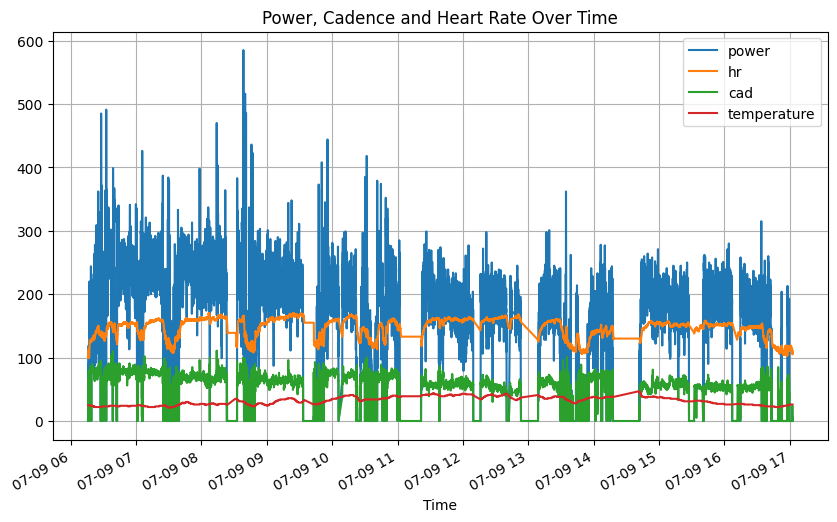

In [9]:
close_px = df[['power','hr','cad','temperature']]
close_px.plot(kind='line',
              figsize=(10, 6),
              title='Power, Cadence and Heart Rate Over Time',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()


/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_99589/149609467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  move_px['gradient'] = move_px['alt_difference'].mul(100).div(move_px['distance'].replace(0, np.nan))


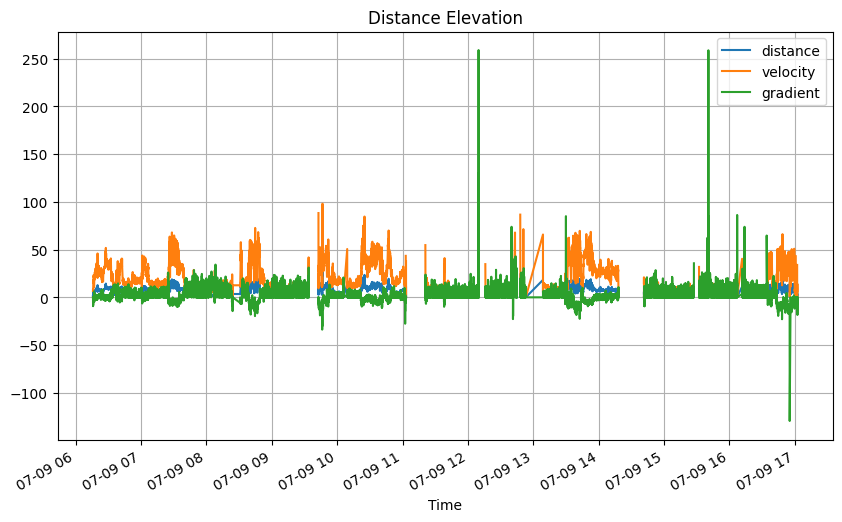

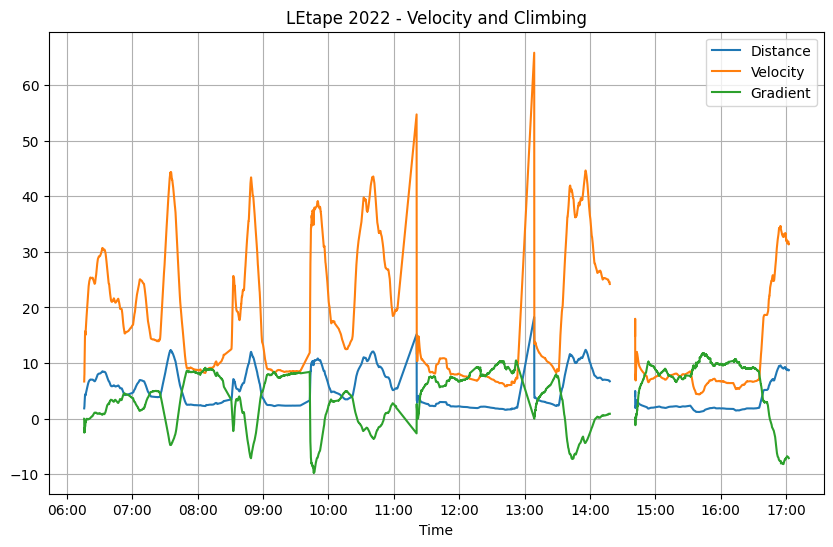

In [10]:
import matplotlib.dates as mdates


move_px = df[['distance','alt_difference','velocity']]

move_px['gradient'] = move_px['alt_difference'].mul(100).div(move_px['distance'].replace(0, np.nan))

move_px = move_px.drop(columns=['alt_difference'])

move_px.plot(kind='line',
              figsize=(10, 6),
              title='Distance Elevation',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()

rolling_mean = move_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Distance', 'Velocity', 'Gradient'])
plt.title('L''Etape 2022 - Velocity and Climbing')
plt.grid(True)
plt.show()

In [11]:
move_px

,distance,velocity,gradient
time,,,
2023-07-09 06:15:52,NaN,NaN,NaN
2023-07-09 06:15:53,1.858790,6.691643,0.000000
2023-07-09 06:15:54,1.882690,6.777686,0.000000
2023-07-09 06:15:55,1.988027,7.156898,0.000000
2023-07-09 06:15:56,2.435492,8.797283,-8.211894
...,...,...,...
2023-07-09 17:02:24,0.501334,1.804803,0.000000
2023-07-09 17:02:25,0.235335,0.847207,0.000000
2023-07-09 17:02:26,0.222310,0.800315,0.000000


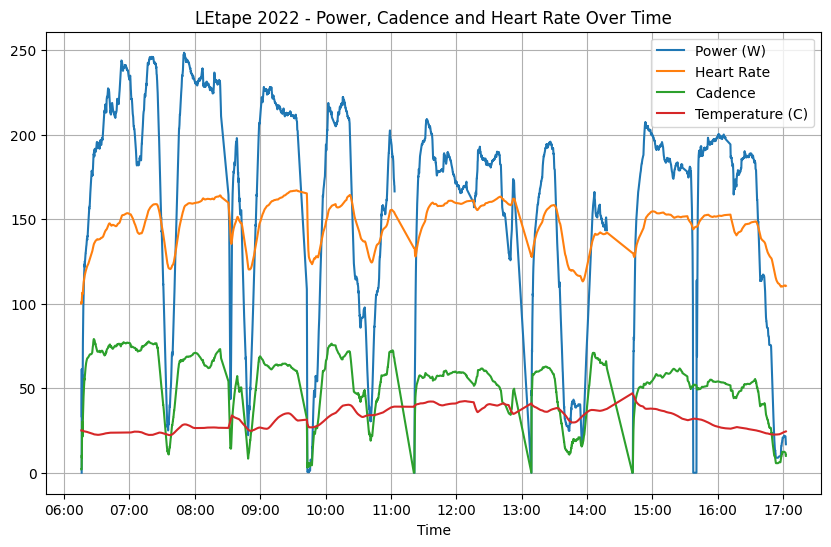

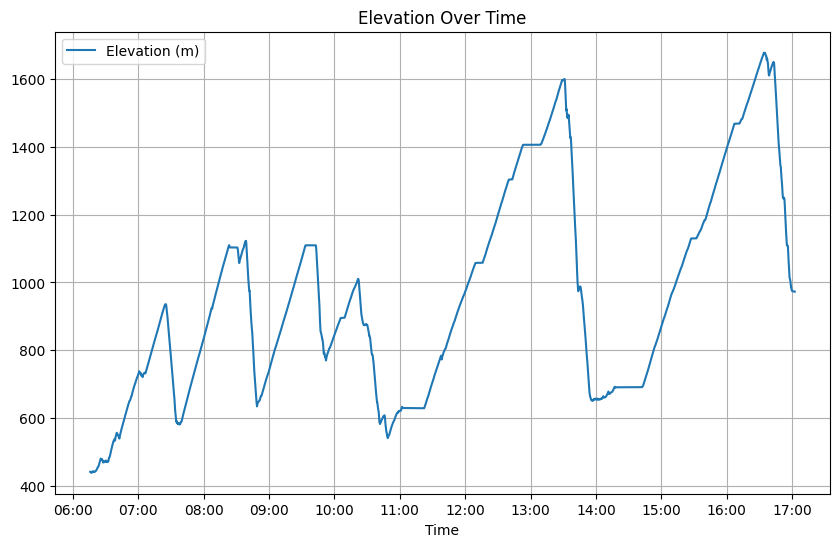

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

rolling_mean = close_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Power (W)', 'Heart Rate', 'Cadence', 'Temperature (C)'])
plt.title('L''Etape 2022 - Power, Cadence and Heart Rate Over Time')
plt.grid(True)
plt.show()

elevation = df[['ele']]
plt.figure(figsize=(10, 6))
plt.plot(elevation.index, elevation)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Elevation (m)'])
plt.title('Elevation Over Time')
plt.grid(True)
plt.show()

Calculate values for [Physical Activity - Activity-based Measures](https://build.fhir.org/ig/HL7/physical-activity/measures.html#activity-based-measures)

Convert to FHIR Bundle (type = collection)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression


df['gradient'] = df['alt_difference'].mul(100).div(df['distance'].replace(0, np.nan))

strava = df[['power','hr','cad','temperature'
    ,'distance'
    ,'gradient'
   # ,'velocity'
             ]].dropna()

stravaT = strava[['hr','cad','temperature'
    ,'power'
    ,'gradient'
  #  ,'velocity'
                  ]]
X = pd.DataFrame(scale(stravaT))
y = strava.distance

print(f"Shape of X: {X.shape}")  # Check original shapes
print(f"Shape of y: {y.shape}")


X_Train, X_Test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 4200)

lm = LinearRegression()
lm.fit(X_Train,y_train)

Shape of X: (31924, 5)
Shape of y: (31924,)


LinearRegression()

In [14]:
print(f"R2 : {lm.score(X_Train, y_train):0.3}")

R2 : 0.705


In [15]:
for coef, column in zip(lm.coef_, stravaT.columns):
    print(f"{column}: {round(coef, 1)}")

stravaT.mean()



hr: -1.7
cad: 0.4
temperature: -0.2
power: -1.0
gradient: -1.1


hr             147.665393
cad             54.511653
temperature     31.598108
power          166.053784
gradient         4.080098
dtype: float64

In [16]:
stravaT.std()

hr             15.398085
cad            24.783176
temperature     6.462429
power          83.739696
gradient        6.953338
dtype: float64

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_Train,y_train >= 1)

from sklearn.metrics import accuracy_score

in_sample_acc = accuracy_score(y_train>=35, lr.predict(X_Train))
out_sample_acc = accuracy_score(y_test>=35, lr.predict(X_Test))

print(f'In sample accurary {in_sample_acc:0.3}')
print(f'Out sample accurary {out_sample_acc:0.3}')

In sample accurary 0.000861
Out sample accurary 0.00047


In [18]:
for var, coef,strat in zip(X_Train.columns, lr.coef_[0],stravaT.columns):
    print(f'{strat:11} {var:7} : {coef:0.3}')

hr                0 : -1.03
cad               1 : 2.69
temperature       2 : -0.421
power             3 : 0.145
gradient          4 : -0.82


In [19]:
X_Train.columns

RangeIndex(start=0, stop=5, step=1)